# Bacon-Shor [[4,1,1,2]] Subsystem Code: Energy Spectrum Analysis

Publication-quality figures showing energy spectrum evolution under RAP protocol
with gauge penalization for the Bacon-Shor subsystem code.

This notebook uses the shared `qec_config` module for all parameters,
quantum operators, and utility functions.

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

# Add parent directory to path for qec_config import
sys.path.insert(0, os.path.dirname(os.getcwd()))

from qec_config import BaconShorConfig, PlotConfig

# Apply publication-quality plot settings
PlotConfig.apply()

print("="*70)
print("BACON-SHOR [[4,1,1,2]] SUBSYSTEM CODE - ENERGY SPECTRUM ANALYSIS")
print("="*70)

BACON-SHOR [[4,1,1,2]] SUBSYSTEM CODE - ENERGY SPECTRUM ANALYSIS


## Initialize Configuration

Load RAP parameters and initialize the Bacon-Shor code operators.

In [2]:
# Initialize configuration
config = BaconShorConfig(n_points=1001)
config.info()

Bacon-Shor [[4,1,1,2]] Subsystem Code
  omega_max = 25.0 MHz
  T_max     = 4.0 us
  n_points  = 1001
------------------------------------------------------------
  Logical: |0_L> = (|0000>+|1111>)/sqrt(2)
  Gauge: X1X2, Z1Z3, X3X4, Z2Z4


## Compute Energy Spectra

Compute energy eigenvalues for different penalty strengths:
- **Ep = 0**: No penalization (logical states within error manifold)
- **Ep = 25 MHz**: Moderate separation
- **Ep = 100 MHz**: Strong confinement to logical subspace

In [3]:
# Ep values to compute (in MHz)
Ep_values_MHz = [0, 25, 100]

print("Loading/computing energy spectra...")

# Store results
all_results = {}

for Ep_MHz in Ep_values_MHz:
    Ep_rad = config.Ep_MHz_to_rad(Ep_MHz)
    
    if Ep_MHz == 0:
        # For Ep=0, use projected tracking for cleaner results
        E0, E1, idx_series = config.track_logical_projected(Ep=Ep_rad, pulse_type='gaussian')
        energies = {0: E0, 1: E1}
        # No error states for projected tracking
        for i in range(2, config.dim):
            energies[i] = np.full_like(E0, np.nan)
    else:
        # Use full spectrum tracking with caching
        energies, idx_series = config.get_or_compute_spectrum(
            Ep=Ep_rad, pulse_type='gaussian'
        )
    
    all_results[Ep_MHz] = {
        'energies': energies,
        'idx_series': idx_series
    }

print("Done!")

Loading/computing energy spectra...
  Computing spectrum for Ep = 25.0 MHz...
    Saved to: spectrum_bacon_shor_gaussian_Ep25.0MHz_cc22094e6af7.npz
  Computing spectrum for Ep = 100.0 MHz...
    Saved to: spectrum_bacon_shor_gaussian_Ep100.0MHz_7501fffb2996.npz
Done!


## Create Thesis-Quality Figure

Three-panel figure showing the effect of increasing penalty strength.

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp



Figures saved:
  -> ../figs/bacon_shor_energy_spectrum_thesis.pdf
  -> ../figs/bacon_shor_energy_spectrum_thesis.png


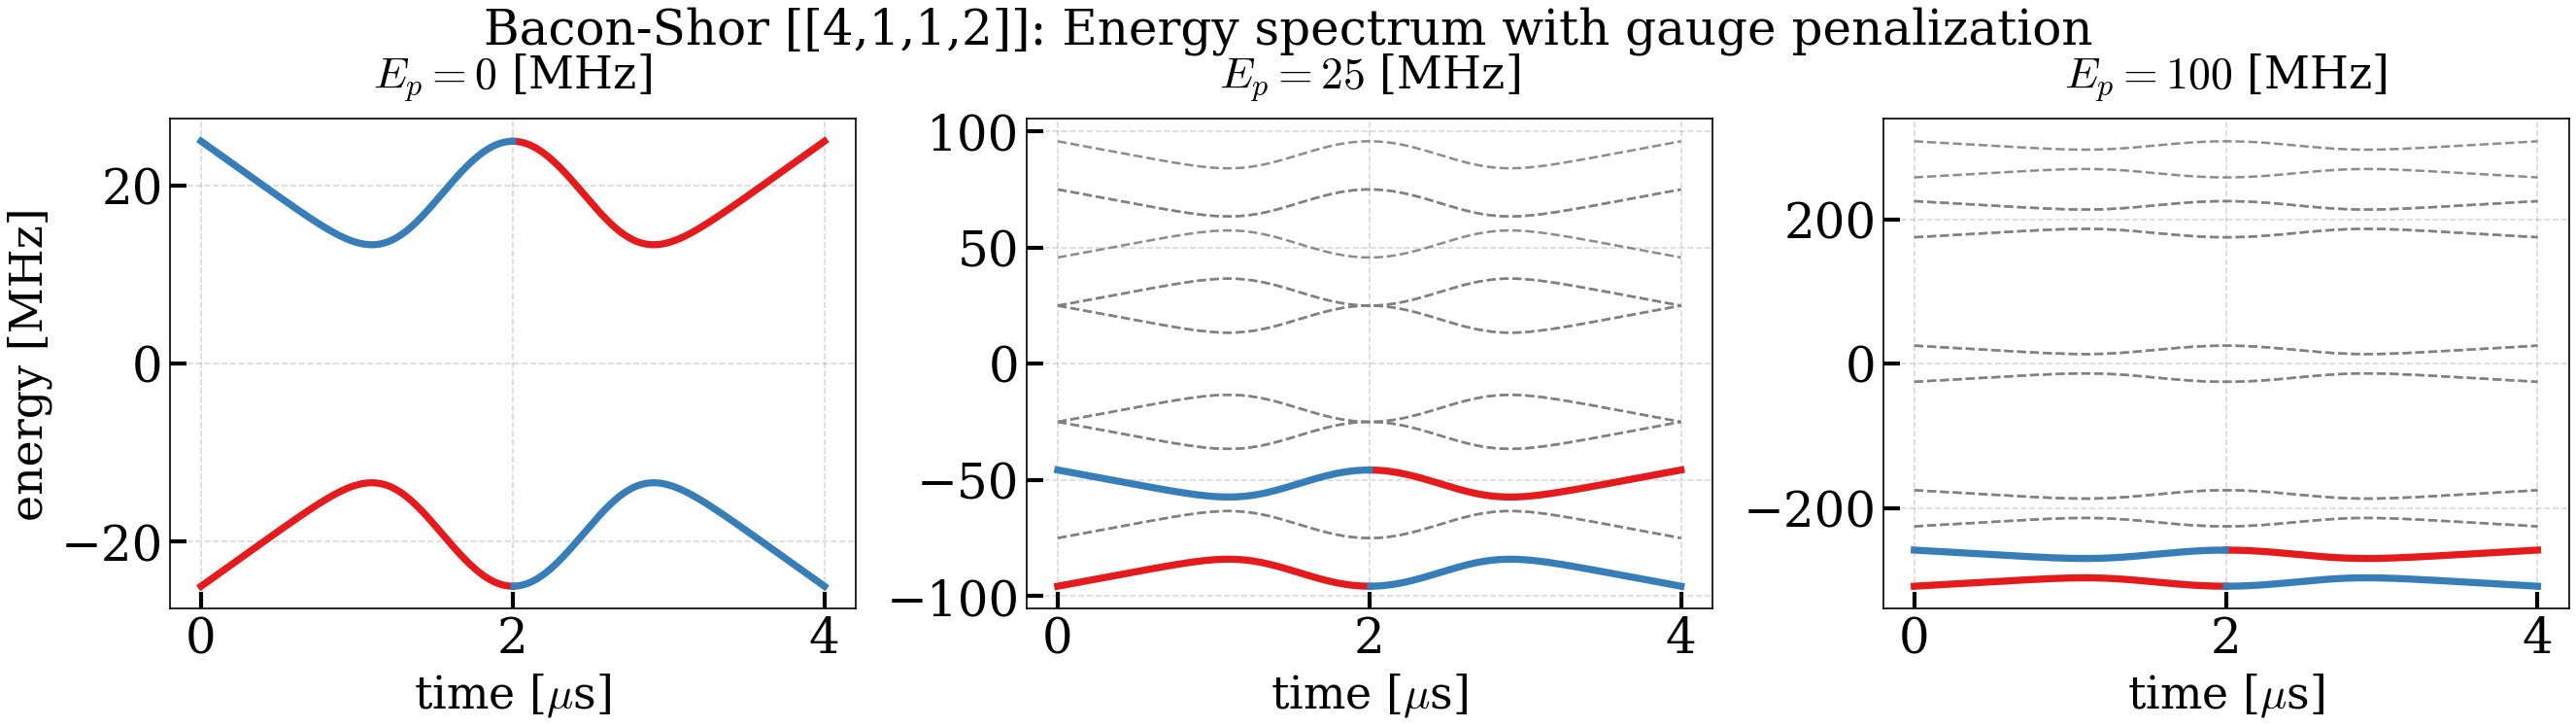

In [4]:
# Convert time to plotting units
t_plot = config.t_list * config.TO_TIME_UNITS  # to us

# Colors
colors_main = PlotConfig.COLORS_LOGICAL

# Create figure
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, Ep_MHz in enumerate(Ep_values_MHz):
    ax = axes[idx]
    result = all_results[Ep_MHz]
    energies = result['energies']
    idx_series = result['idx_series']
    
    # Convert energies to MHz
    E0 = energies[0] * config.TO_FREQ_UNITS
    E1 = energies[1] * config.TO_FREQ_UNITS
    
    # Break at swap points
    E0_broken = config.break_at_swaps(E0, idx_series[0])
    E1_broken = config.break_at_swaps(E1, idx_series[1])
    
    # Plot logical states
    ax.plot(t_plot, E0_broken, color=colors_main[0], linewidth=3.5,
            label=r'$|0_L\rangle$', zorder=10)
    ax.plot(t_plot, E1_broken, color=colors_main[1], linewidth=3.5,
            label=r'$|1_L\rangle$', zorder=10)
    
    # Plot error states (skip for Ep=0 which uses projected tracking)
    if Ep_MHz > 0:
        error_plotted = False
        for i in range(2, config.dim):
            err_arr = energies[i] * config.TO_FREQ_UNITS
            if not np.all(np.isnan(err_arr)):
                label = 'Error states' if not error_plotted else None
                ax.plot(t_plot, err_arr, color='gray', linewidth=1.2,
                        linestyle='--', alpha=0.9, label=label, zorder=5)
                error_plotted = True
    
    # Styling
    ax.set_xlabel(r'time [$\mu$s]', fontsize=22)
    if idx == 0:
        ax.set_ylabel('energy [MHz]', fontsize=22)
    ax.set_title(f'$E_p = {Ep_MHz}$ [MHz]', fontsize=22, pad=15)
    ax.tick_params(axis='both', which='major', labelsize=24, width=2, length=8)
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.8, zorder=0, color='gray')

plt.tight_layout()
plt.suptitle('Bacon-Shor [[4,1,1,2]]: Energy spectrum with gauge penalization',
             fontsize=24, y=1.02)

# Save figures
os.makedirs('../figs', exist_ok=True)
plt.savefig('../figs/bacon_shor_energy_spectrum_thesis.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.savefig('../figs/bacon_shor_energy_spectrum_thesis.png', format='png', dpi=300, bbox_inches='tight')

print(f"\nFigures saved:")
print(f"  -> ../figs/bacon_shor_energy_spectrum_thesis.pdf")
print(f"  -> ../figs/bacon_shor_energy_spectrum_thesis.png")
plt.show()

## Gap Analysis

Calculate the RAP gap and code-to-error gap.

In [5]:
# Compute gaps between Ep=0 and Ep=100 MHz
Ep_0_rad = 0
Ep_100_rad = config.Ep_MHz_to_rad(100)

# Get full spectrum for gap calculation
energies_no_pen, _ = config.get_or_compute_spectrum(Ep=Ep_0_rad, pulse_type='gaussian')
energies_with_pen, _ = config.get_or_compute_spectrum(Ep=Ep_100_rad, pulse_type='gaussian')

gaps = config.compute_gaps(energies_no_pen, energies_with_pen)

print(f"\nGap Analysis (Bacon-Shor [[4,1,1,2]]):")
print(f"  Delta_RAP = {gaps['delta_rap']:.3f} MHz (at t = {gaps['t_delta_rap']:.2f} us)")
print(f"  Delta_min(Ep=100 MHz) = {gaps['delta_min_ep']:.3f} MHz (at t = {gaps['t_delta_min_ep']:.2f} us)")
if gaps['delta_rap'] > 0:
    print(f"  Ratio Delta_min/Delta_RAP = {gaps['delta_min_ep']/gaps['delta_rap']:.2f}")

  Computing spectrum for Ep = 0.0 MHz...
    Saved to: spectrum_bacon_shor_gaussian_Ep0.0MHz_a583b317d328.npz
  Loaded cached data for Ep = 100.0 MHz

Gap Analysis (Bacon-Shor [[4,1,1,2]]):
  Delta_RAP = 0.000 MHz (at t = 0.07 us)
  Delta_min(Ep=100 MHz) = 32.843 MHz (at t = 4.00 us)


## Comparison with 3-Qubit Repetition Code

Side-by-side comparison of energy spectra.

Computing comparison spectra...
  Loaded cached data for Ep = 50.0 MHz
  Loaded cached data for Ep = 50.0 MHz


'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp



Comparison figures saved:
  -> ../figs/subsystem_vs_repetition_spectrum.pdf
  -> ../figs/subsystem_vs_repetition_spectrum.png


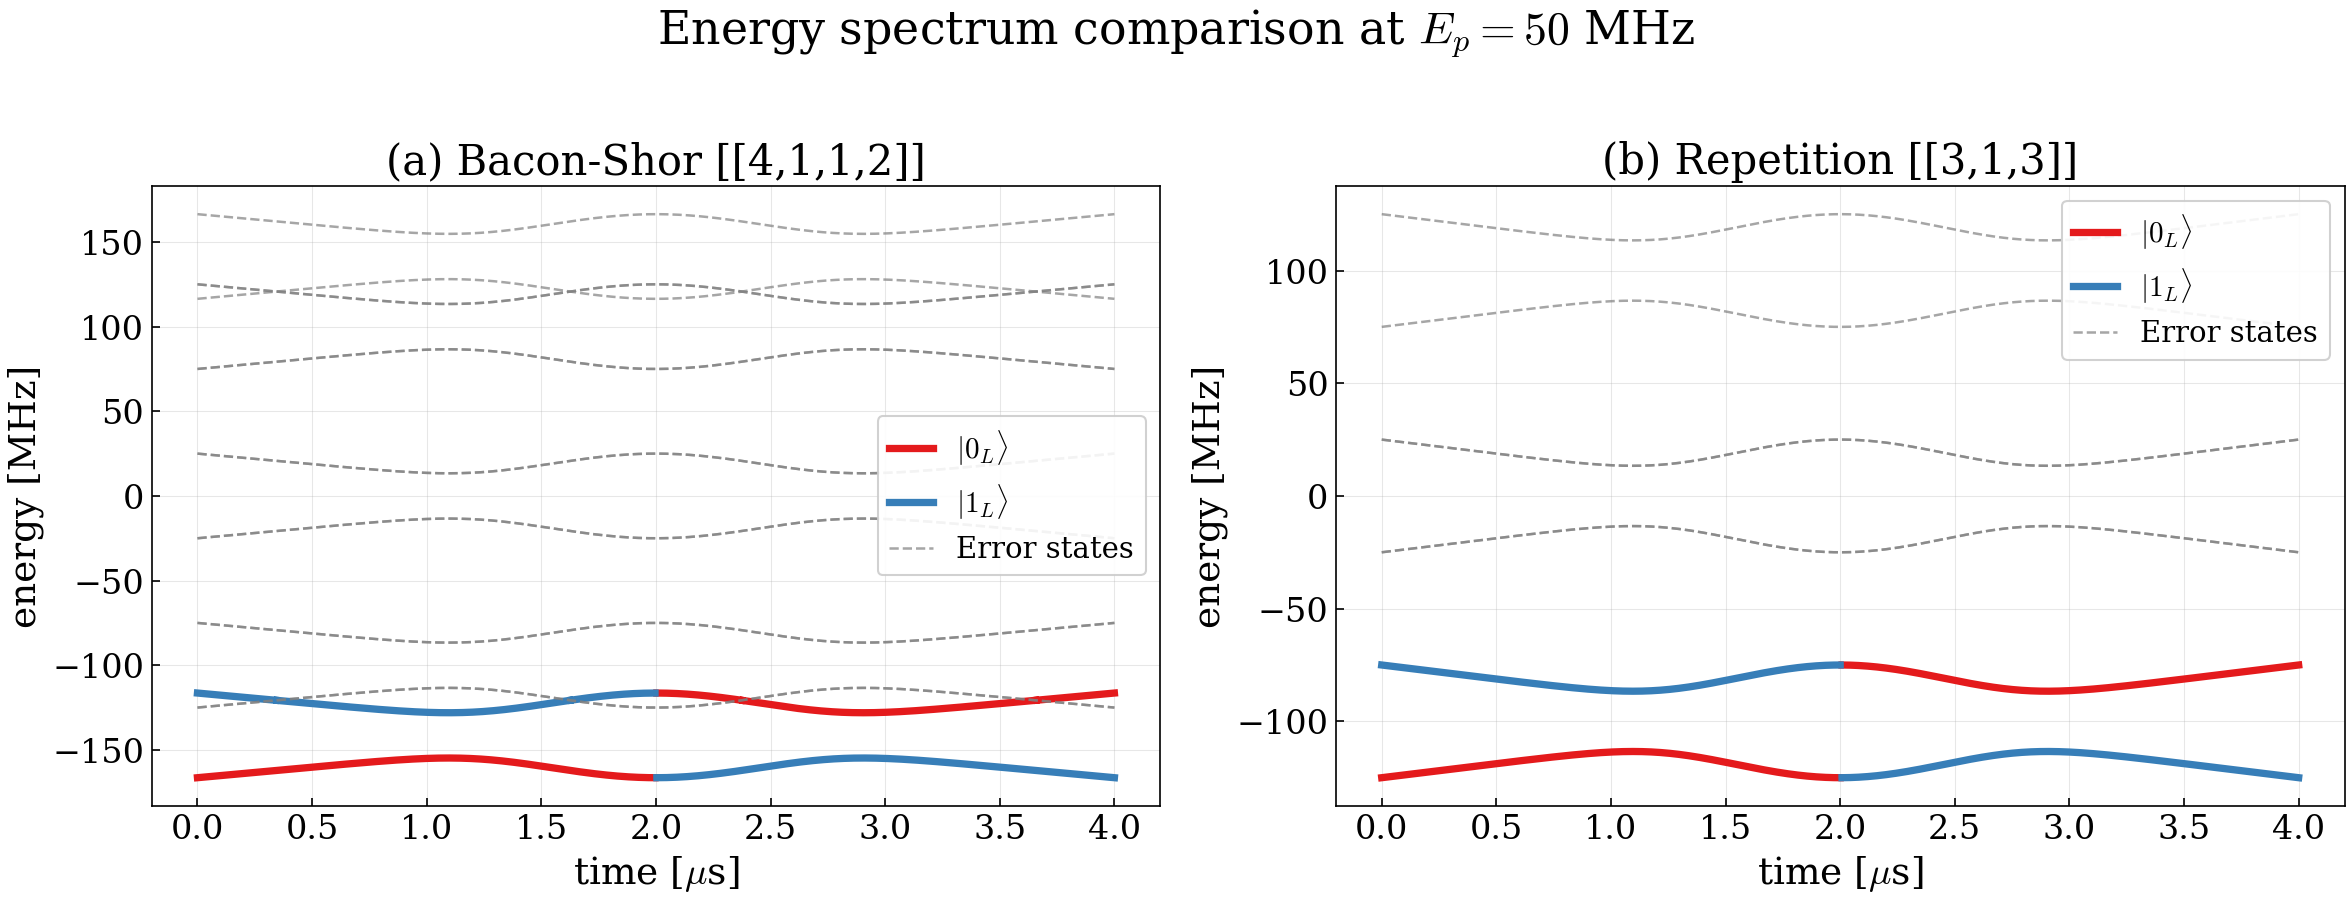

In [6]:
from qec_config import QECConfig

# Initialize repetition code config
rep_config = QECConfig(n_points=1001)

# Compute spectrum for Ep=50 MHz for both codes
Ep_50_rad = config.Ep_MHz_to_rad(50)

print("Computing comparison spectra...")

# Bacon-Shor
bs_energies, bs_idx = config.get_or_compute_spectrum(Ep=Ep_50_rad, pulse_type='gaussian')

# Repetition code
rep_energies, rep_idx = rep_config.get_or_compute_spectrum(Ep=Ep_50_rad, pulse_type='gaussian')

# Create comparison figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Bacon-Shor
t_bs = config.t_list * config.TO_TIME_UNITS
E0_bs = config.break_at_swaps(bs_energies[0] * config.TO_FREQ_UNITS, bs_idx[0])
E1_bs = config.break_at_swaps(bs_energies[1] * config.TO_FREQ_UNITS, bs_idx[1])

ax1.plot(t_bs, E0_bs, color=colors_main[0], linewidth=3.5, label=r'$|0_L\rangle$')
ax1.plot(t_bs, E1_bs, color=colors_main[1], linewidth=3.5, label=r'$|1_L\rangle$')
for i in range(2, config.dim):
    err = bs_energies[i] * config.TO_FREQ_UNITS
    label = 'Error states' if i == 2 else None
    ax1.plot(t_bs, err, color='gray', linewidth=1.2, linestyle='--', alpha=0.7, label=label)

ax1.set_xlabel(r'time [$\mu$s]', fontsize=18)
ax1.set_ylabel('energy [MHz]', fontsize=18)
ax1.set_title('(a) Bacon-Shor [[4,1,1,2]]', fontsize=20)
ax1.tick_params(axis='both', labelsize=16)
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=14)

# Repetition code
t_rep = rep_config.t_list * rep_config.TO_TIME_UNITS
E0_rep = rep_config.break_at_swaps(rep_energies[0] * rep_config.TO_FREQ_UNITS, rep_idx[0])
E1_rep = rep_config.break_at_swaps(rep_energies[1] * rep_config.TO_FREQ_UNITS, rep_idx[1])

ax2.plot(t_rep, E0_rep, color=colors_main[0], linewidth=3.5, label=r'$|0_L\rangle$')
ax2.plot(t_rep, E1_rep, color=colors_main[1], linewidth=3.5, label=r'$|1_L\rangle$')
for i in range(2, rep_config.dim):
    err = rep_energies[i] * rep_config.TO_FREQ_UNITS
    label = 'Error states' if i == 2 else None
    ax2.plot(t_rep, err, color='gray', linewidth=1.2, linestyle='--', alpha=0.7, label=label)

ax2.set_xlabel(r'time [$\mu$s]', fontsize=18)
ax2.set_ylabel('energy [MHz]', fontsize=18)
ax2.set_title('(b) Repetition [[3,1,3]]', fontsize=20)
ax2.tick_params(axis='both', labelsize=16)
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=14)

plt.suptitle(f'Energy spectrum comparison at $E_p = 50$ MHz', fontsize=22, y=1.02)
plt.tight_layout()

plt.savefig('../figs/subsystem_vs_repetition_spectrum.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.savefig('../figs/subsystem_vs_repetition_spectrum.png', format='png', dpi=300, bbox_inches='tight')

print(f"\nComparison figures saved:")
print(f"  -> ../figs/subsystem_vs_repetition_spectrum.pdf")
print(f"  -> ../figs/subsystem_vs_repetition_spectrum.png")
plt.show()